In [ ]:
!cp /content/drive/MyDrive/Auslan/Code_Fest_slt.zip ./

!unzip Code_Fest_slt.zip

!cp -r /content/drive/MyDrive/Auslan/Features/* ./data/Features/

!cp -r /content/drive/MyDrive/Auslan/Dataset/* ./data/

!unzip dataset/train.zip data/train

!unzip dataset/test.zip data/test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


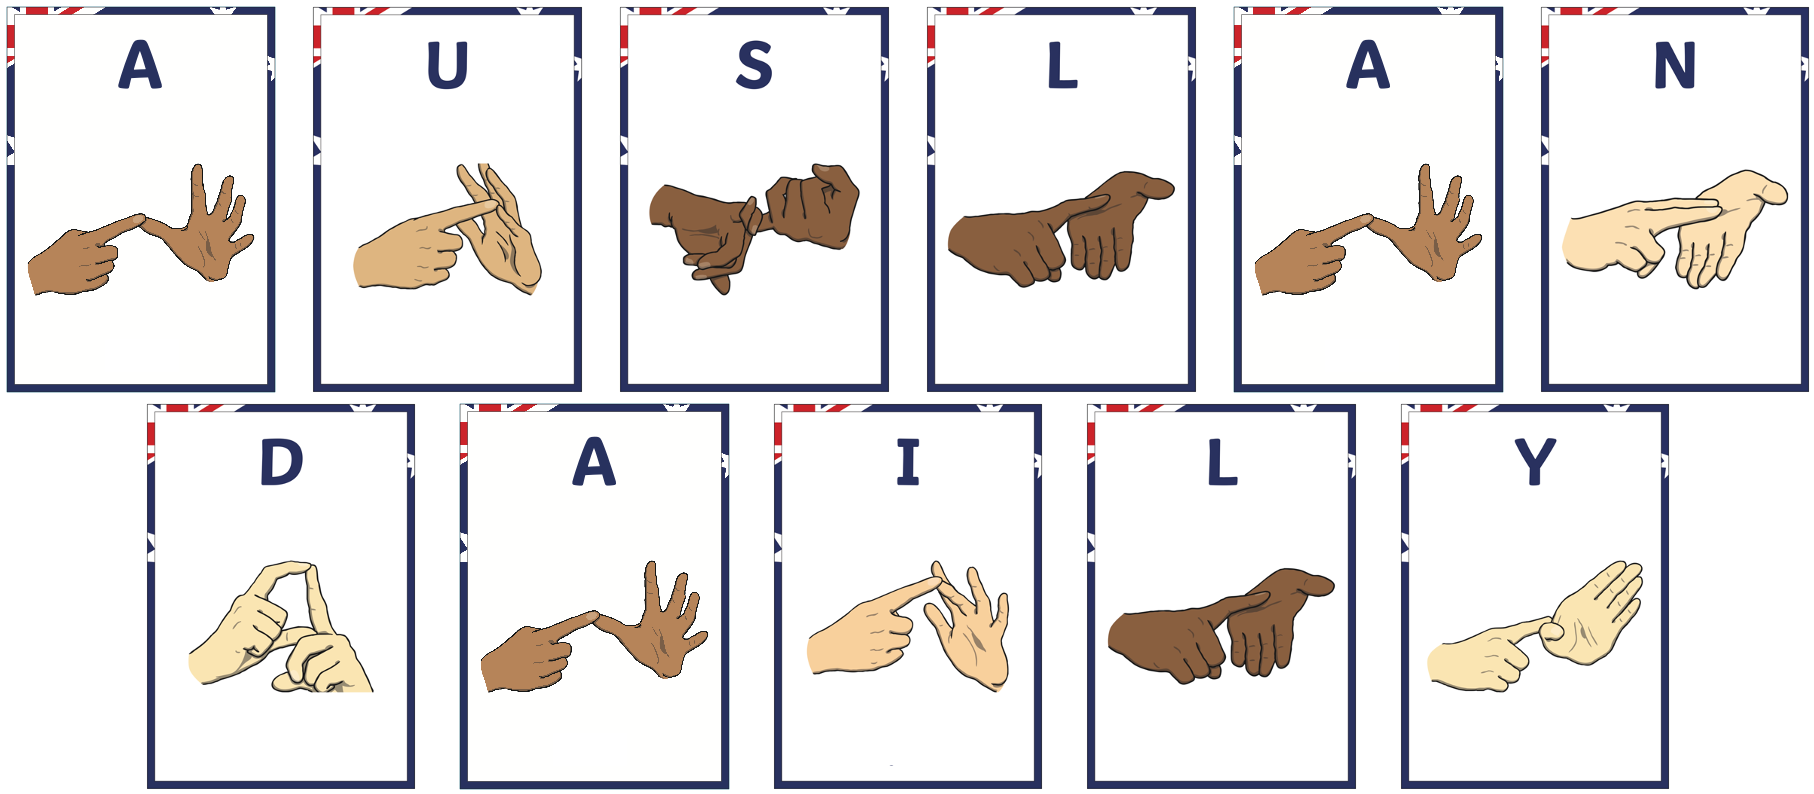

# Dataset for _<span style="color: red;">AI FOR AUSLAN</span>_:
### Auslan-Daily Communication
- Data source: [_Sally and Possum_](https://earlychildhood.qld.gov.au/early-years/sally-possum)
- Total number of sign video clips: 14041
- Total number of signers: ~50
- ...


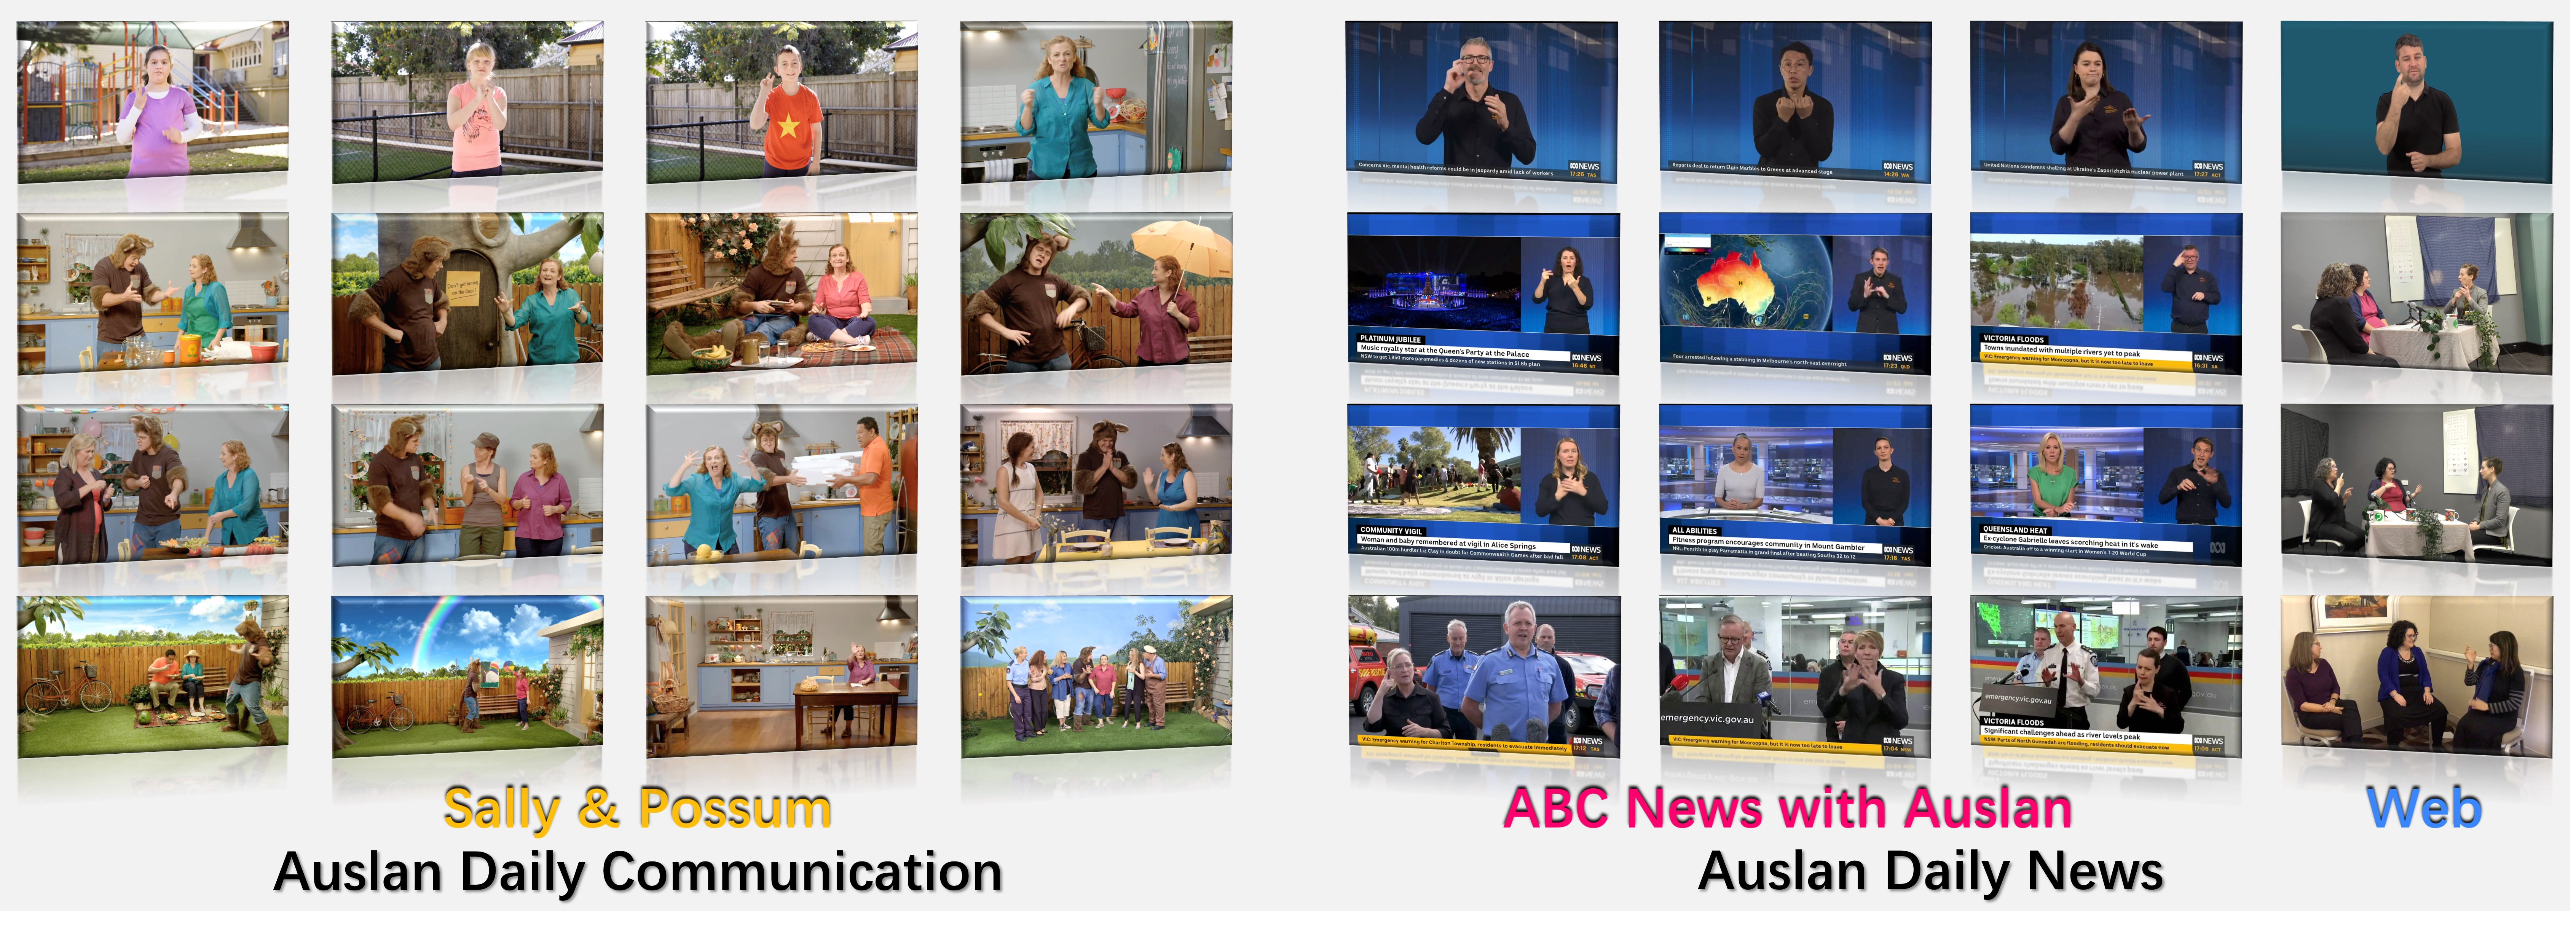

# <span style="color: blue;">Contents:</span>
**1. Dataset Download**
- 1.1 Data Split
- 1.2 Feautre Format
  - Pose-Based Feature
  - RGB-Based Feature
  
**2. Baseline Code**
- Seq2Seq Architecture
- Hyper-parameters
- Post-Processing
- Evaluation
- Usage

**3. Submission**

**4. Future Suggests**
- Video Embedding
- Model Design

# 1. Dataset Download
Google Drive [Link](https://drive.google.com/drive/folders/1w_MOEjqTbI6DZB03c_vxoaGXNaF4GB06)
- **Auslan_Daily_Intro.pptx**: Auslan-Daily introduction powerpoint.
- **Data_Split**:
 - **train.csv**: train data **with** label
 - **train.zip**: sign video clips for train set
 - **submission.csv**: test data **without** label
 - **test.zip**: sign video clips for test set
- **Features**:
 - **SP_pose**: pose-based video clip features
 - **SP_S_s16s2**: RGB-based video clip features


In [ ]:
# load packages
import os
import pandas as pd
import pickle
import gzip
import torch
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

## Helper Funcation

In [ ]:
def read_pkl(file):
    f = gzip.open(file, "rb")
    data = pickle.load(f)
    return data

def save_pkl(data, name):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)
    print(name,"Finish!")


RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
YELLOW = (0, 255, 255)
ORANGE = (0, 165, 255)
PURPLE = (255, 0, 255)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

def vis_alphapose(frame, im_res, opt, vis_thres):
    '''
    frame: frame image
    im_res: im_res of predictions
    format: coco or mpii
    return rendered image
    '''
    kp_num = 17
    if len(im_res['result']) > 0:
        kp_num = len(im_res['result'][0]['keypoints'])


    l_pair = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 18), (6, 18), (5, 7), (7, 9), (6, 8), (8, 10),# Body
        (17, 18), (18, 19), #(19, 11), (19, 12),
#         (11, 13), (12, 14), (13, 15), (14, 16),
#         (20, 24), (21, 25), (23, 25), (22, 24), (15, 24), (16, 25),# Foot
        (26, 27),(27, 28),(28, 29),(29, 30),(30, 31),(31, 32),(32, 33),(33, 34),(34, 35),(35, 36),(36, 37),(37, 38),#Face
        (38, 39),(39, 40),(40, 41),(41, 42),(43, 44),(44, 45),(45, 46),(46, 47),(48, 49),(49, 50),(50, 51),(51, 52),#Face
        (53, 54),(54, 55),(55, 56),(57, 58),(58, 59),(59, 60),(60, 61),(62, 63),(63, 64),(64, 65),(65, 66),(66, 67),#Face
        (68, 69),(69, 70),(70, 71),(71, 72),(72, 73),(74, 75),(75, 76),(76, 77),(77, 78),(78, 79),(79, 80),(80, 81),#Face
        (81, 82),(82, 83),(83, 84),(84, 85),(85, 86),(86, 87),(87, 88),(88, 89),(89, 90),(90, 91),(91, 92),(92, 93),#Face
        (94,95),(95,96),(96,97),(97,98),(94,99),(99,100),(100,101),(101,102),(94,103),(103,104),(104,105),#LeftHand
        (105,106),(94,107),(107,108),(108,109),(109,110),(94,111),(111,112),(112,113),(113,114),#LeftHand
        (115,116),(116,117),(117,118),(118,119),(115,120),(120,121),(121,122),(122,123),(115,124),(124,125),#RightHand
        (125,126),(126,127),(115,128),(128,129),(129,130),(130,131),(115,132),(132,133),(133,134),(134,135)#RightHand
    ]
    p_color = [(0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),  # Nose, LEye, REye, LEar, REar
               (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),  # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
               (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127),  # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
               (77, 255, 255), (0, 255, 255), (77, 204, 255),  # head, neck, shoulder
               (0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0), (77, 255, 255)] # foot

    line_color = [(0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
                  (0, 255, 102), (77, 255, 222), (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77),
                  (77, 191, 255), (204, 77, 255), (77, 222, 255), (255, 156, 127),
                  (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36),
                  (0, 77, 255), (0, 77, 255), (0, 77, 255), (0, 77, 255), (255, 156, 127), (255, 156, 127)]

    # im_name = os.path.basename(im_res['imgname'])
    img = frame.copy()
    height, width = img.shape[:2]
    for human in im_res['result']:
        part_line = {}
        kp_preds = human['keypoints']
        kp_scores = human['kp_score']
        if kp_num == 17:
            kp_preds = torch.cat((kp_preds, torch.unsqueeze((kp_preds[5, :] + kp_preds[6, :]) / 2, 0)))
            kp_scores = torch.cat((kp_scores, torch.unsqueeze((kp_scores[5, :] + kp_scores[6, :]) / 2, 0)))
            vis_thres.append(vis_thres[-1])
        if opt["tracking"]:
            while isinstance(human['idx'], list):
                human['idx'].sort()
                human['idx'] = human['idx'][0]
            color = get_color_fast(int(abs(human['idx'])))
        else:
            color = BLUE


        # Draw keypoints
        for n in range(kp_scores.shape[0]):
            if kp_scores[n] <= vis_thres[n]:
                continue
            cor_x, cor_y = int(kp_preds[n, 0]), int(kp_preds[n, 1])
            part_line[n] = (int(cor_x), int(cor_y))
            bg = img.copy()
            if n < len(p_color):
                if opt["tracking"]:
                    cv2.circle(bg, (int(cor_x), int(cor_y)), 5, color, -1)
                else:
                    cv2.circle(bg, (int(cor_x), int(cor_y)), 10, p_color[n], -1)
            else:
                cv2.circle(bg, (int(cor_x), int(cor_y)), 3, (255,255,255), 2)
            # Now create a mask of logo and create its inverse mask also
            if n < len(p_color):
                transparency = float(max(0, min(1, kp_scores[n])))
            else:
                transparency = float(max(0, min(1, kp_scores[n]*2)))
            img = bg
        # Draw limbs
        for i, (start_p, end_p) in enumerate(l_pair):
            if start_p in part_line and end_p in part_line:
                start_xy = part_line[start_p]
                end_xy = part_line[end_p]
                bg = img.copy()

                X = (start_xy[0], end_xy[0])
                Y = (start_xy[1], end_xy[1])
                mX = np.mean(X)
                mY = np.mean(Y)
                length = ((Y[0] - Y[1]) ** 2 + (X[0] - X[1]) ** 2) ** 0.5
                angle = math.degrees(math.atan2(Y[0] - Y[1], X[0] - X[1]))
                stickwidth = (kp_scores[start_p] + kp_scores[end_p]) + 1
                polygon = cv2.ellipse2Poly((int(mX), int(mY)), (int(length/2), int(stickwidth)), int(angle), 0, 360, 1)
                if i < len(line_color):
                    if opt["tracking"]:
                        cv2.fillConvexPoly(bg, polygon, color)
                    else:
                        cv2.fillConvexPoly(bg, polygon, line_color[i])
                else:
                    cv2.line(bg, start_xy, end_xy, (255,255,255), 8)
                if n < len(p_color):
                    transparency = float(max(0, min(1, 0.5 * (kp_scores[start_p] + kp_scores[end_p])-0.1)))
                else:
                    transparency = float(max(0, min(1, (kp_scores[start_p] + kp_scores[end_p]))))

                #transparency = float(max(0, min(1, 0.5 * (kp_scores[start_p] + kp_scores[end_p])-0.1)))
                img =bg
    return img

def pose2draw_dict(pose):
    res = {}
    pose = list(pose)
    pose = pose[:22] + [0.0] * 12 + pose[22:28]  + [0.0] * 12 + pose[28:]
    x = pose[::2]
    y = pose[1::2]
    conf = [1] * int(len(pose)/2)
    res["keypoints"] = np.array([x,y]).T
    res["kp_score"] = np.array(conf)
#     res["idx"] = idx
#     print(res["idx"])
    return {"result":[res]}

def read_video_frame(video_path, nth_frame):

    cap = cv2.VideoCapture(video_path)
    frame_num = nth_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()

    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print('Unable to read frame')
    cap.release()
    return frame

def video_check(data_frame, video_clip_dir):
    total_video_name = os.listdir(video_clip_dir)
    not_exist_video = []
    cnt = 0

    for i in data_frame["Video_Clip_Name"]:
        if i + "_signer.mp4" not in total_video_name:
            not_exist_video.append(i)
        else:
            cnt += 1
    if len(not_exist_video) > 0:
        print("Some Video Clip Not Exist")
        print(not_exist_video)
    else:
        print("All Video Clip Exist")
        print("Total Video Clips:",cnt)

## 1.1 Data Split

In [ ]:
dataset_path = "data/" # Change to your dataset folder
train_sign_video_clip_path = os.path.join(dataset_path,"train")
test_sign_video_clip_path = os.path.join(dataset_path,"test")
train_df = pd.read_csv(dataset_path + "train.csv", index_col = 0)
test_df = pd.read_csv(dataset_path + "submission.csv", index_col = 0)
print("Num.train data:", len(train_df),"Num.train video clips:", len(os.listdir(train_sign_video_clip_path)))
print("Num.test data:", len(test_df),"Num.test video clips:", len(os.listdir(test_sign_video_clip_path)))

Num.train data: 13241 Num.train video clips: 13241
Num.test data: 800 Num.test video clips: 800


In [ ]:
print(train_df.shape)
train_df.head(20)

(13241, 3)


Video_Clip_Name                                           Subtitle  \
0        video_1_0                                            hello .   
1        video_1_1                                             look .   
2        video_1_2                                             look .   
3        video_1_3                                       i am sally .   
4        video_1_5                                            hello .   
5        video_1_6                                            hello .   
6        video_1_7                                          hold on .   
7        video_1_8                   my fingers were stuck together .   
8        video_1_9                   i could not say hello properly .   
9       video_1_10       now they are nice and clean hello everyone .   
10      video_1_11          i am making some glue it is very sticky .   
11      video_1_12  i am making this glue because i want to make a...   
12      video_1_13  i am sure possum would love to help make this ...   
13      video_1_14                          i wonder if he is awake .   
14      video_1_15                                i will go and see .   
15      video_1_16                       come on let us have a look .   
16      video_1_17                                  where is possum .   
17      video_1_18  sally my door was so hard to open i do not kno...   
18      video_1_19                              was it stuck possum .   
19      video_1_20                       sally what does stuck mean .   

                                       Lemm_Subtitile  
0                                             hello .  
1                                              look .  
2                                              look .  
3                                        i be sally .  
4                                             hello .  
5                                             hello .  
6                                           hold on .  
7                       my finger be stick together .  
8                    i could not say hello properly .  
9         now they be nice and clean hello everyone .  
10            i be make some glue it be very sticky .  
11  i be make this glue because i want to make a p...  
12  i be sure possum would love to help make this ...  
13                          i wonder if he be awake .  
14                                i will go and see .  
15                       come on let us have a look .  
16                                  where be possum .  
17  sally my door be so hard to open i do not know...  
18                               be it stick possum .  
19                         sally what do stuck mean .

Lemm_Subtitile: sign language lacks tenses and plural forms, we will perform **lemmatization** on the natural language text (English).
- Method: from nltk.stem import WordNetLemmatizer


In [ ]:
# Check All Train Video Clip Exist
print("Checking Train")
video_check(train_df, train_sign_video_clip_path)

Checking Train
All Video Clip Exist
Total Video Clips: 13241


In [ ]:
print(test_df.shape)
test_df.head()

(800, 1)


Inference
Video_Clip_Name           
video_1_4              NaN
video_1_31             NaN
video_1_47             NaN
video_2_4              NaN
video_2_8              NaN

In [ ]:
# Check All Test Video Clip Exist
print("Checking Test")
# video_check(test_df, test_sign_video_clip_path)

## 1.2 Feature Format
Our baseline model is [1], where features are saved in the same format as [1].

**Feature Format** (train.pkl, val.pkl, test_feature.pkl)
- **LIST** of data
 - **name: current video clip name**
 - gloss: -1 (No Gloss annotation)
 - **text: current English subtitle (-1 for test_feature.pkl)**
 - number_frames: number of total frames for current video clip
 - signer: signer ID for current video clip
 - **sign: current video clip feature**

[1] Sign Language Transformers: Sign Language Transformers: Joint End-to-end Sign Language Recognition and Translation.[Paper Link](https://www.cihancamgoz.com/pub/camgoz2020cvpr.pdf) [Code Link](https://github.com/neccam/slt)

### 1.2.1 SP_pose: pose-based video clip features

In [ ]:
# Train Example
pose_path = os.path.join(dataset_path, "Features/SP_pose/val.pkl")
pose_data = read_pkl(pose_path)
pose_data[0]

{'name': 'video_1_15',
 'gloss': '-1',
 'text': 'i will go and see .',
 'num_frames': np.int64(20),
 'signer': np.int64(1),
 'sign': array([[ 946.86633301,  243.49481201,  980.99688721, ...,  377.1713562 ,
          767.2456665 ,  386.6401062 ],
        [ 962.92388916,  237.80984497, 1004.91394043, ...,  356.78262329,
          716.35455322,  360.20849609],
        [ 981.90411377,  247.6231842 , 1025.17211914, ...,  342.85455322,
          628.49304199,  328.74816895],
        ...,
        [ 973.43530273,  287.47262573,  997.33483887, ...,  490.53112793,
          903.69366455,  494.57925415],
        [ 973.81665039,  288.70947266,  997.60443115, ...,  500.55825806,
          907.94244385,  506.47845459],
        [ 972.76495361,  289.38693237,  996.52111816, ...,  505.9125061 ,
          900.3616333 ,  510.53509521]])}

In [ ]:
# Test Example
pose_path = os.path.join(dataset_path, "Features/SP_pose/test_feature.pkl")
pose_data = read_pkl(pose_path)
pose_data[0]

{'name': 'video_1_4',
 'gloss': '-1',
 'text': -1,
 'num_frames': np.int64(54),
 'signer': np.int64(2),
 'sign': array([[1271.73730469,  312.86782837, 1299.90612793, ...,  884.99798584,
         1210.4161377 ,  881.15783691],
        [1277.45800781,  307.35025024, 1305.82946777, ...,  877.19226074,
         1192.78881836,  873.49884033],
        [1301.71826172,  302.60641479, 1340.12817383, ...,  877.24713135,
         1190.1171875 ,  869.96948242],
        ...,
        [1295.33911133,  295.00769043, 1324.5489502 , ...,  887.37207031,
         1093.69543457,  876.37127686],
        [1306.54736328,  296.86929321, 1335.69506836, ...,  888.71868896,
         1096.1706543 ,  876.62628174],
        [1306.55004883,  296.7973938 , 1335.70336914, ...,  889.7947998 ,
         1096.86755371,  877.6427002 ]])}

#### [Alphapose](https://github.com/MVIG-SJTU/AlphaPose)
AlphaPose is an accurate multi-person pose estimator, which is the first open-source system that achieves 70+ mAP (75 mAP) on COCO dataset and 80+ mAP (82.1 mAP) on MPII dataset. To match poses that correspond to the same person across frames, we also provide an efficient online pose tracker called Pose Flow. It is the first open-source online pose tracker that achieves both 60+ mAP (66.5 mAP) and 50+ MOTA (58.3 MOTA) on PoseTrack Challenge dataset.
![](./Image/pose.jpg)

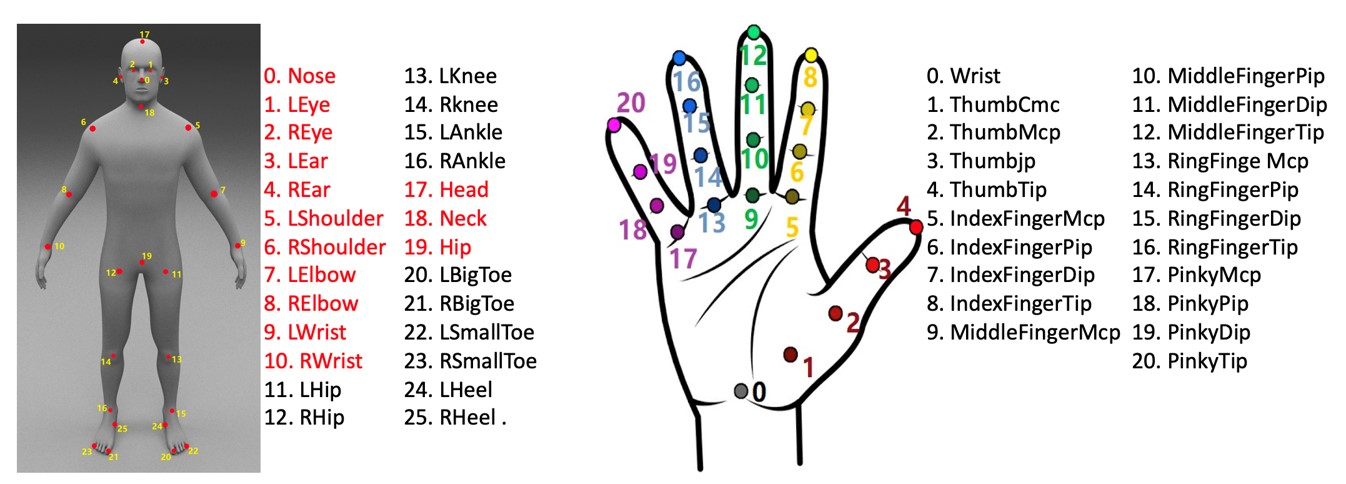

#### Pose visualization

Current Data: video_3_9
Current Subtitle: i wonder what that be .


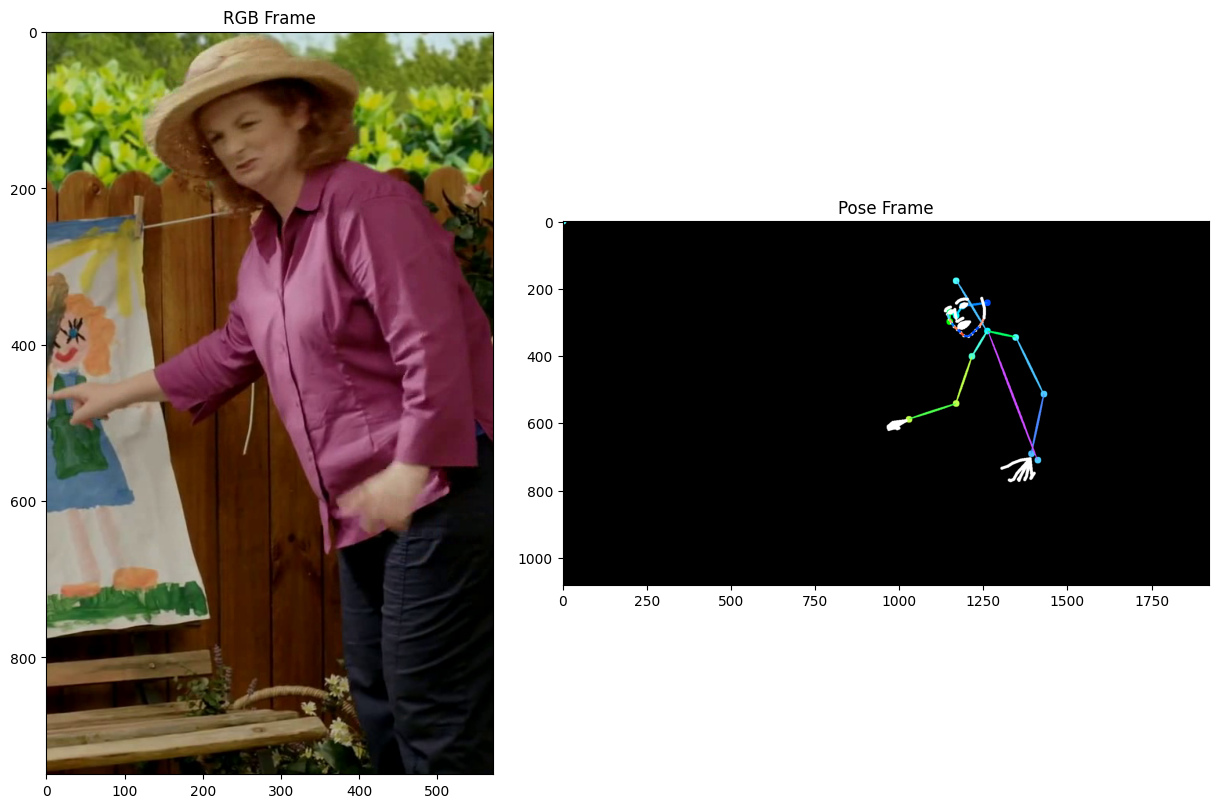

In [ ]:
pose_path = os.path.join(dataset_path, "Features/SP_pose/val.pkl")
pose_data = read_pkl(pose_path)
current_data = pose_data[11] # select one data sample
video_name = current_data["name"]
print("Current Data:", video_name)
print("Current Subtitle:", current_data["text"])
pose = current_data["sign"]
# ----------------------------------------------------------
# len(pose) = 248
# body 14 * 2 --- pose[0:28]
# face 68 * 2 --- pose[28:164]
# hands 2 * 21 * 2 --- pose[164:]
# ----------------------------------------------------------
check_frame = 20 # choose visual pose frame
draw_pose = pose[check_frame]
im_res = pose2draw_dict(draw_pose)
frame = np.zeros((1080, 1920, 3), dtype=np.uint8) # black background
opt = {"tracking":False, "showbox":False}
vis_thres = [0]*136
pose_frame = vis_alphapose(frame, im_res, opt, vis_thres) # signer pose frame with black background
sign_video_clip_path = os.path.join(train_sign_video_clip_path,video_name + "_signer.mp4")
video_frame = read_video_frame(sign_video_clip_path, check_frame) # signer RGB Frame

fig = plt.figure(figsize = (15,20))
plt.subplots_adjust(wspace=-0.2)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(122)

ax1.imshow(video_frame)
ax1.set_title('RGB Frame')

ax2.imshow(pose_frame)
ax2.set_title('Pose Frame')
plt.show()


### 1.2.2 SP_S_s16s2: RGB-based video clip features
Several models directly extract features from sign videos, such S3D and I3D. For this work, I3D is used for sign video representation. To better adapt to SL dataset and capture the spatio-temporal information of signs, inspired by TSPNet [1], we finetune I3D on a word-level sign language recognition [2] dataset and extract sign video features with different window widths and strides.

We use the pre-trained I3D model form [2] and features with a window width of 16 and a stride of 2 are extracted:
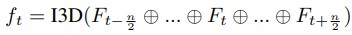
where ft is the representation of the t-th frame, n is the window width, and ⊕ denotes the
concatenation operation.

The **Data Format** is the **same** as the **pose features**.

[1] TSPNet: Hierarchical Feature Learning via Temporal Semantic Pyramid for Sign Language Translation.[NIPS20](https://arxiv.org/abs/2010.05468)

[2] Word-level Deep Sign Language Recognition from Video: A New Large-scale Dataset and Methods Comparison.[WACV20](https://arxiv.org/abs/1910.11006)


# 2. Baseline Code

## 2.1 Seq2Seq Architecture
- **RNN-based Framework:**

 - Recurrent Neural Network (RNN) is a classic sequence model widely used for tasks involving sequential data.
RNN processes variable-length sequences by passing hidden states between recurrent layers to capture long-term dependencies.
 - RNN is well-suited for sequence-to-sequence tasks like machine translation, language generation, and speech recognition.
 - Common variants of RNN include Simple RNN, LSTM (Long Short-Term Memory), and GRU (Gated Recurrent Unit).

- **Transformer-based Framework:**

 - Transformer-based models are a revolutionary architecture initially introduced for machine translation, such as Google's "Transformer" model.
 - Transformers employ self-attention mechanism to capture dependencies between different positions in a sequence, avoiding traditional recurrent structures.
 - The Transformer model consists of an encoder and a decoder, used for encoding input sequences and generating output sequences, respectively.
 - Transformer frameworks are applicable to various natural language processing tasks like text classification, named entity recognition, and question answering.
 - A prominent variant of the Transformer model is BERT (Bidirectional Encoder Representations from Transformers), which utilizes pre-training to generate universal language representations for downstream task fine-tuning.

**Summary:**
RNN-based frameworks are traditional sequence models suitable for tasks with temporal dependencies, while Transformer-based frameworks are built upon the self-attention mechanism, catering to various natural language processing tasks. Both frameworks have achieved significant success in language modeling, machine translation, text generation, and more, each with its own strengths and applicability. The choice between them depends on the task characteristics, data nature, and specific modeling requirements.

#### <span style="color: green;">Recurrent Neural Network (RNN)</span> :
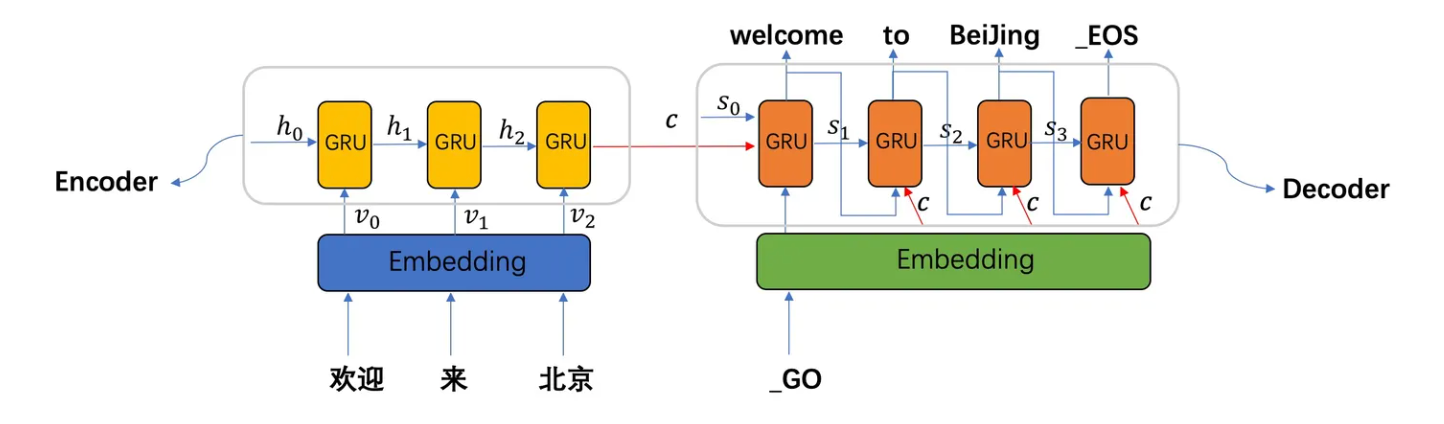

#### <span style="color: green;">Sign Language Transformer</span> :
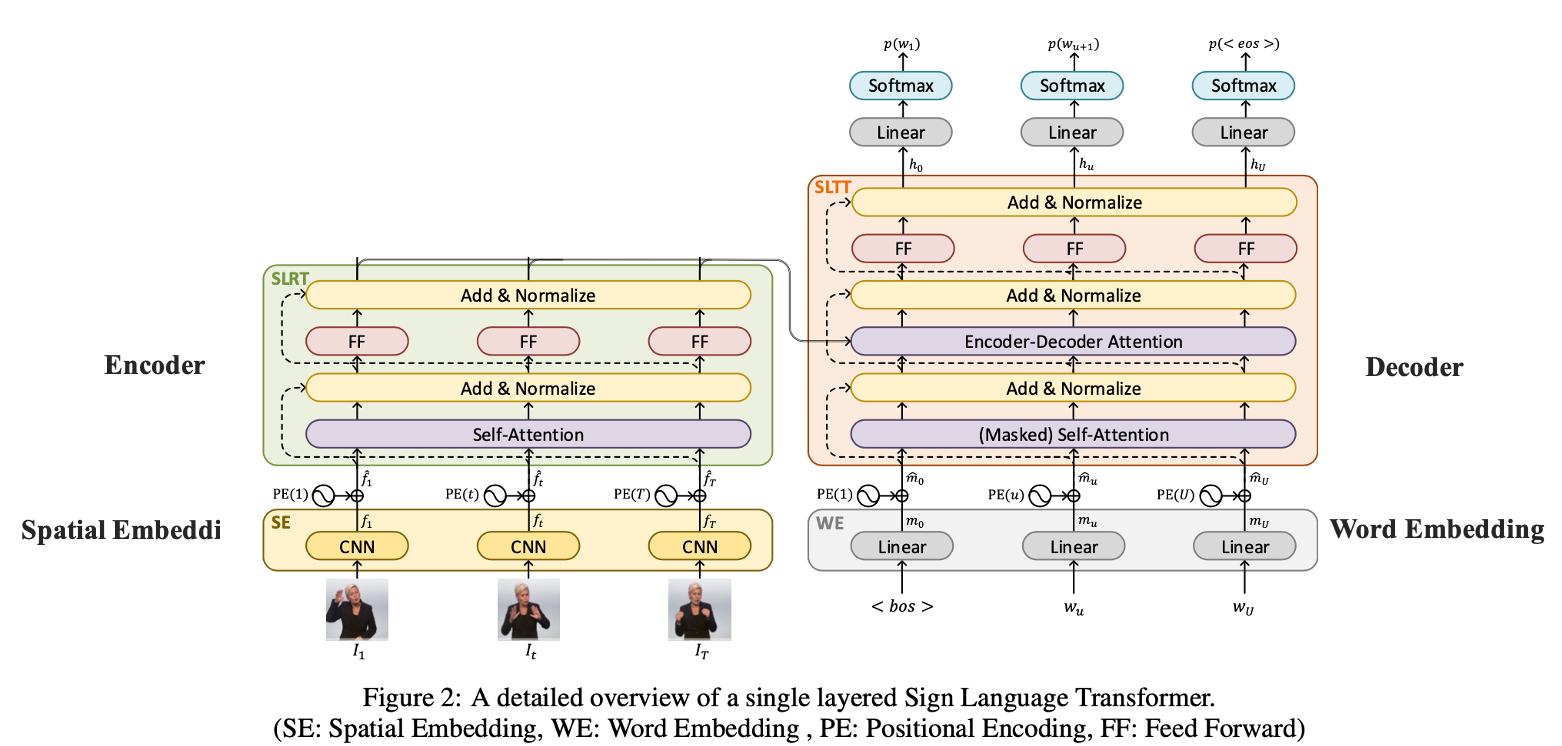

## 2.2 Hyper-parameters
- **data -> feature**: use different video clip features. **"RGB" or ["hands", "body", "face"]**.
- **model -> encoder -> type & model -> decoder -> type**: use different Seq2Seq architecture. **"rnn" or "transformer"**.
- **training -> recognition_loss_weight**: the weight of CSLR loss (set 0.0).

## 2.3 Post-Processing —— Beam Search

*   List item
*   List item


[**Beam Search**](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24) is a method for decoding a sequence given an auto-regressive function that outputs a probability distribution over the next possible symbols.
- translation_beam_sizes [1]: size of the beam.
- translation_beam_alphas [2]: &alpha; factor for length penalty.

[1]  [Beam Search, How It Works](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)

[2] Google’sNeural Machine Translation System: Bridging the Gap Between Human and Machine Translation (2016). [Link](https://arxiv.org/abs/1609.08144) .



## 2.4 Evaluation Bleu Score
**Bleu Score (Bilingual Evaluation Understudy Score)** is a metric used to evaluate the quality of machine translations. It measures the similarity between a machine-translated sentence and one or more reference translations.

The Bleu Score calculates the precision of n-grams (contiguous sequences of n words) in the machine translation by comparing them to the reference translations. It then computes a weighted average of these precisions, taking into account different n-gram lengths. The resulting score ranges from 0 to 1, with higher scores indicating better translation quality.

Bleu Score is widely used in the field of machine translation research and evaluation. It provides an objective measure to compare and assess different machine translation systems or approaches. By quantifying the degree of similarity between the machine-generated translations and human references, Bleu Score helps researchers and developers in improving and optimizing machine translation algorithms.

In [ ]:
from signjoey.metrics import bleu
GT = ["i am A ."]
hyp = ["i am B ."]
bleu(GT, hyp)

## 2.5 Code Usage
- **train:** python -m signjoey train configs/xx.yaml
- **test:** python -m signjoey test configs/xx.yaml
- **translate (for TEST):** python -m signjoey translate configs/xx.yaml

In [ ]:
!python -m signjoey train configs/sign_SP_H_B_RNN_L3.yaml

2025-07-03 14:01:14.329016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751551274.372016   11280 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751551274.386288   11280 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 14:01:14.464930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 14:01:22.558300: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [ ]:
from BLEU import BLEU_Score
GT = "/media/xins/xinS1/Coding_Fest/GT_test_ref.csv"
# hyp = "/media/xins/xinS1/Coding_Fest/Coding_Fest_slt/sign_SP_RGB_Trans_E3D3/test_hyp.csv"
hyp = "/media/xins/xinS1/Coding_Fest/Coding_Fest_slt/sign_SP_H_B_RNN_L3/test_hyp.csv"
BLEU_Score(GT, hyp)

# 3. Submission

- Step 1: Submission Page ([Link](http://www.codingfest.top/)).
- Step 2: Login (USERNAME & PASSWORD).
- Step 3: Submit Result (file name: **submission.csv** with **_Video_Clip_Name_** and **_Inference_**).

Finish !


# 4. Future Suggests
- Video Embedding:
 - Pose: use a more accurate keypoints estimation model.
 - RGB: use other Word-Level sign language data sets for pre-training, such us MS-ASL[1] and BSL-1k[2].
 - ...

- Model Design:
 - ST-GCN [3]
 - Fusion multi-modal features [4,5]
 - ...

[1] MS-ASL: A Large-Scale Data Set and Benchmark for Understanding American Sign Language. [Paper Link](https://arxiv.org/pdf/1812.01053v2.pdf), [Model Link](https://github.com/gulvarol/bsl1k)

[2] BSL-1K: Scaling up co-articulated sign language recognition using mouthing cues. [Paper Link](https://arxiv.org/abs/2007.12131), [Model Link](https://github.com/gulvarol/bsl1k)

[3] Spatial Temporal Graph Convolutional Networks for Skeleton-Based Action Recognition. [Paper Link](https://arxiv.org/abs/1801.07455)

[4] OpenASL: A Large-Scale Open-Domain Sign Language Translation Dataset. [Paper Link](https://arxiv.org/abs/2205.12870)

[5] Spatial-Temporal Multi-Cue Network for Sign
Language Recognition and Translation  [Paper Link](https://arxiv.org/abs/2205.12870)

# Q & A